<a href="https://colab.research.google.com/github/Blanca-Vern-2nd/EuroSAT_Land_Classification/blob/main/notebooks/Results_under_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Using Tf 2.15 cz ... well its easy to use
!pip uninstall -y tensorflow
!pip install tensorflow==2.15

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling

In [ ]:
#Mounting drive cz google wants me to
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# All the importing stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import zipfile #Bcz we don't have hugeeee enough storage :'(
from matplotlib import image
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
#Unzip~~~
zip_path = '/content/drive/MyDrive/EuroSAT.zip'
extract_path = '/content/dataset/EuroSAT'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Dataset extracted to: {extract_path}")
dataset_folder = '/content/dataset/EuroSAT/2750/'
train_csv_path = '/content/drive/MyDrive/train.csv'
validation_csv_path = '/content/drive/MyDrive/validation.csv'
test_csv_path = '/content/drive/MyDrive/test.csv'
column_names = ["id", "path", "class_id", "class_name"]
training_df = pd.read_csv(train_csv_path, names=column_names, skiprows=1)
validation_df = pd.read_csv(validation_csv_path, names=column_names, skiprows=1)
test_df = pd.read_csv(test_csv_path, names=column_names, skiprows=1)
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)
total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")
#making everything equal!!!!!!
image_height, image_width = 64, 64
batch_size = 64 # Experimental stuff weellll...cz hyperparameter
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = ImageDataGenerator(rescale=1./255)
print("Building training set...")
training_set = train_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

print("\nBuilding validation set...")
validation_set = validation_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\nBuilding test set...")
test_set = validation_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Dataset extracted to: /content/dataset/EuroSAT
Training set size: 18900 (70%)
Validation set size: 5400 (20%)
Test set size: 2700 (10%)
Building training set...
Found 18900 validated image filenames belonging to 10 classes.

Building validation set...
Found 5400 validated image filenames belonging to 10 classes.

Building test set...
Found 2700 validated image filenames belonging to 10 classes.


In [ ]:
class_name_list = np.array(list(training_set.class_indices.keys()))

In [ ]:
base_resnet50 = ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(64, 64, 3),
                pooling=None,
                classes=10,
                classifier_activation='softmax',
            )

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_resnet50)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 27787658 (106.00 MB)
Trainable params: 27734538 (105.80 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model_path = "/content/eurosat_rgb_resnet50_model.h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 15 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=25,
    verbose=1,
)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.8489

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/296 [==============================] - 77s 121ms/step - loss: 0.5410 - accuracy: 0.8489 - val_loss: 41.9888 - val_accuracy: 0.0924 - lr: 1.0000e-04
Epoch 2/25
296/296 [==============================] - 31s 106ms/step - loss: 0.1384 - accuracy: 0.9573 - val_loss: 21.0591 - val_accuracy: 0.1222 - lr: 1.0000e-04
Epoch 3/25
296/296 [==============================] - 34s 115ms/step - loss: 0.0857 - accuracy: 0.9716 - val_loss: 3.1500 - val_accuracy: 0.4846 - lr: 1.0000e-04
Epoch 4/25
296/296 [==============================] - 32s 107ms/step - loss: 0.0754 - accuracy: 0.9779 - val_loss: 0.4202 - val_accuracy: 0.8928 - lr: 1.0000e-04
Epoch 5/25
296/296 [==============================] - 32s 107ms/step - loss: 0.0478 - accuracy: 0.9852 - val_loss: 0.2346 - val_accuracy: 0.9369 - lr: 1.0000e-04
Epoch 6/25
296/296 [==============================] - 32s 109ms/step - loss: 0.0391 - accuracy: 0.9877 - val_loss: 0.1969 - val_accuracy: 0.9515 - lr: 1.0000e-04
Epoch 7/25
296/296 [=================

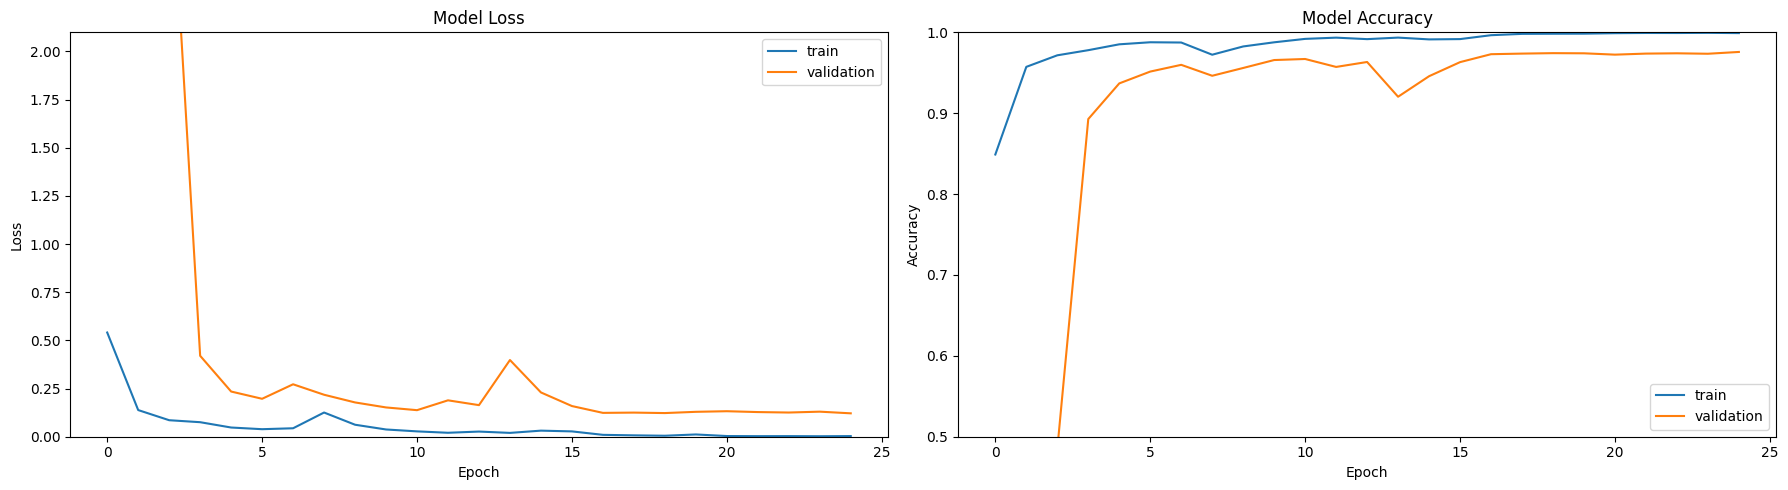

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.ylim(0, max(history.history["loss"] + history.history["val_loss"]) *0.05)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()
plt.savefig("/content/vgg19_original_loss_accuracy.png")


In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print("Test Loss:", loss, "\nTest Accuracy:", accuracy)

43/43 [==============================] - 2s 54ms/step - loss: 0.0890 - accuracy: 0.9837
Test Loss: 0.08902817219495773 
Test Accuracy: 0.9837037324905396


197/197 [==============================] - 3s 17ms/step - loss: 3.9149 - accuracy: 0.8437
Test Loss with FGSM-perturbed Images: 3.9149274826049805
Test Accuracy with FGSM-perturbed Images: 0.8437103033065796


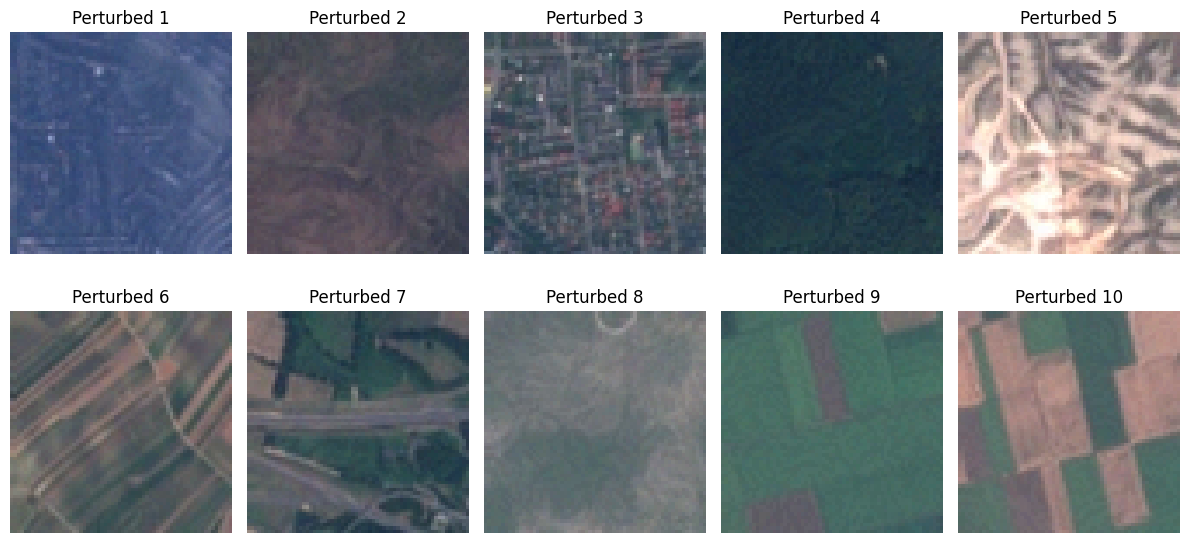

In [ ]:
def fgsm_attack(image, epsilon, gradient):
    signed_grad = tf.sign(gradient)
    perturbed_image = image + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

epsilon = 0.01
test_images, test_labels = [], []
for _ in range(100):
    img, label = next(test_set)
    test_images.extend(img)
    test_labels.extend(label)

test_images, test_labels = np.array(test_images), np.array(test_labels)
perturbed_images = []

os.makedirs("/content/adversarial_images", exist_ok=True)
for idx, img in enumerate(test_images):
    img_tensor = tf.convert_to_tensor(img.reshape(1, *img.shape))
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)
        loss = tf.keras.losses.categorical_crossentropy(test_labels[0].reshape(1, -1), prediction)
    gradient = tape.gradient(loss, img_tensor)
    perturbed_img = fgsm_attack(img_tensor, epsilon, gradient)
    perturbed_images.append(perturbed_img.numpy().squeeze())
    plt.imsave(f"/content/adversarial_images/perturbed_image_{idx + 1}.png", perturbed_img.numpy().squeeze())
perturbed_images = np.array(perturbed_images)
loss, accuracy = model.evaluate(perturbed_images, test_labels, verbose=1)
print(f"Test Loss with FGSM-perturbed Images: {loss}\nTest Accuracy with FGSM-perturbed Images: {accuracy}")
def plot_images(images):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Perturbed {i + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_images(perturbed_images[:10])
